In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from pathlib import Path
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook
from src.utils import get_project_dir

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

PROJECT_DIR = get_project_dir()


# Data Wrangling and Exploration

This notebook assumes that the command `python src/data/make_dataset.py data/external data/raw {img_type}` has already been run with image types `shirt`, `dress` and `toptee` to download and create the necessary JPG image datasets in `data/raw`.

In [3]:
data_ext_path = f'{PROJECT_DIR}/data/external'
data_raw_path = f'{PROJECT_DIR}/data/raw'


## 1. Investigate missing images

When downloading the images, it was easy to notice that some of the URLs were no longer available. As a result, the images couldn't be downloaded.
- What does that mean for this project? Does it mean that we won't have sufficient data to build a model?

In [4]:
# Read sample_counts.json and convert into dataframe format
sample_counts = pd.read_json(f'{data_ext_path}/sample_counts.json', orient='index').reset_index()
sample_counts.columns = ['idx', 'count']
sample_counts = pd.concat([pd.DataFrame(sample_counts['idx'].str.split('.').to_list()), sample_counts['count']], axis=1)
sample_counts = sample_counts.pivot(index=0, columns=1, values='count')
sample_counts['total'] = sample_counts.sum(axis=1)
sample_counts

1,test,train,val,total
0,,,,
dress,3818,11452,3817,19087
shirt,6346,19036,6346,31728
toptee,5374,16121,5373,26868


We compare the missing data to the `sample_counts` dataframe to see how many images of each image and split type we don't have.

In [5]:
img_types = ['dress', 'shirt', 'toptee']
split_types = ['test', 'train', 'val']

missing_dfs = []

for img_type in img_types:
    missing_df = pd.read_csv(f'{data_raw_path}/{img_type}/missing_imgs.csv', index_col=0)
    missing_dfs.append(missing_df.reset_index(drop=True))
    print(f'Number of missing images for {img_type}:', len(missing_df))
    print('Fraction of imgs missing:', round(len(missing_df) / sample_counts.loc[img_type, 'total'], 2))

    for split_type in split_types:
        missing_df_split = missing_df[missing_df['split_type'] == split_type]
        print(f'Fraction of imgs missing from {split_type} split:',
                round(len(missing_df_split) / sample_counts.loc[img_type, split_type], 2))

    print()

Number of missing images for dress: 904
Fraction of imgs missing: 0.05
Fraction of imgs missing from test split: 0.05
Fraction of imgs missing from train split: 0.05
Fraction of imgs missing from val split: 0.04

Number of missing images for shirt: 846
Fraction of imgs missing: 0.03
Fraction of imgs missing from test split: 0.03
Fraction of imgs missing from train split: 0.03
Fraction of imgs missing from val split: 0.02

Number of missing images for toptee: 538
Fraction of imgs missing: 0.02
Fraction of imgs missing from test split: 0.02
Fraction of imgs missing from train split: 0.02
Fraction of imgs missing from val split: 0.02



It looks like we're missing 5% of images from the dress images, 3% from the shirt images, and 2% from the toptee images. Each split has approximately an equal percentage of missing images - since none of the fractions are all that big, it isn't expected that to have a significant effect on the model training or results.

In [6]:
adjusted_sample_counts = sample_counts.copy()

for i, missing_df in enumerate(missing_dfs):
    img_type = img_types[i]
    missing_split_sizes = missing_df.groupby('split_type').size()
    for split_type in split_types:
        adjusted_sample_counts.loc[img_type, split_type] -= missing_split_sizes.loc[split_type]
    
adjusted_sample_counts['total'] = adjusted_sample_counts[split_types].sum(axis=1)
adjusted_sample_counts

1,test,train,val,total
0,,,,
dress,3616,10907,3660,18183
shirt,6163,18526,6193,30882
toptee,5283,15771,5276,26330


Confirm / validate these numbers with the actual directory sizes.

In [7]:
# ensure that files counted end with .jpg
for dirpath, dirnames, filenames in os.walk(data_raw_path):
    img_type, split_type = dirpath.split('/')[-2:]
    if img_type not in img_type or split_type not in split_types:
        continue
    assert adjusted_sample_counts.loc[img_type, split_type] == len([f for f in filenames if f.endswith('.jpg')])

print('All directory sizes match!')

All directory sizes match!


## 2. Create `sample_counts.json` accounting for missing images
We'll save the adjusted sample counts as a new JSON file in `data/raw`.

In [8]:
adj_sample_counts_json = pd.melt(adjusted_sample_counts.reset_index(), id_vars=[0], value_vars=split_types)
adj_sample_counts_json.index = adj_sample_counts_json[0] + '.' + adj_sample_counts_json[1]
adj_sample_counts_json = adj_sample_counts_json['value'].sort_index()
adj_sample_counts_json.to_json(f'{data_raw_path}/sample_counts.json')
adj_sample_counts_json

dress.test       3616
dress.train     10907
dress.val        3660
shirt.test       6163
shirt.train     18526
shirt.val        6193
toptee.test      5283
toptee.train    15771
toptee.val       5276
Name: value, dtype: int64

## 3. Investigate captions
- How many caption "quotes" does each caption item have? (seems to usually be 2)
- How many captions in total for each split?
- How do the caption counts compare to the image counts (including missing images)?
- How many captions is each image a candidate for?
- How many captions is each image a target for?

We first read in all the caption files into separate dataframes.

In [9]:
caption_dfs = dict.fromkeys(img_types)

for img_type in img_types:
    dfs = []
    for split_type in split_types:
        split_caption_df = pd.read_json(f'{data_ext_path}/captions/cap.{img_type}.{split_type}.json')
        split_caption_df['split_type'] = split_type
        dfs.append(split_caption_df)
    caption_df = pd.concat(dfs, axis=0)
    caption_df['img_type'] = img_type
    caption_dfs[img_type] = caption_df

Does every target-candidate pair have two captions?

In [10]:
for caption_df in caption_dfs.values():
    print(caption_df['captions'].apply(len).unique())

[2]
[2]
[2]


Looks all instances consist of two relative captions. How many (sets of) captions are there for each image and split type?

In [11]:
caption_counts = pd.DataFrame(index=img_types, columns=split_types)

for img_type, caption_df in caption_dfs.items():
    for split_type in split_types:
        caption_counts.loc[img_type, split_type] = len(caption_df[caption_df['split_type'] == split_type])

caption_counts

,test,train,val
dress,2021,5985,2017
shirt,2014,5988,2038
toptee,2053,6027,1961


We plot the caption counts against the image counts (including the missing images).

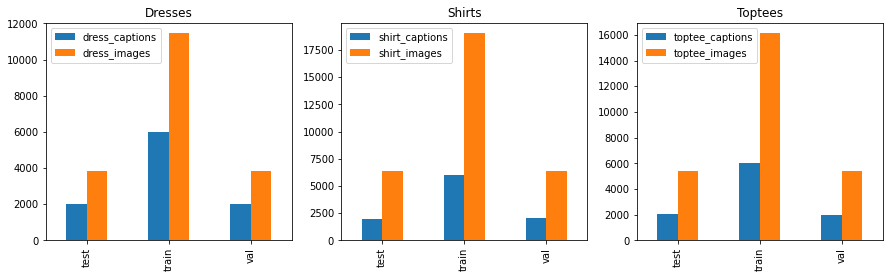

In [12]:
captions_samples = caption_counts.T.join(sample_counts.T, lsuffix='_captions', rsuffix='_images')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

captions_samples[['dress_captions', 'dress_images']].plot.bar(ax=ax[0])
ax[0].set_title('Dresses')

captions_samples[['shirt_captions', 'shirt_images']].plot.bar(ax=ax[1])
ax[1].set_title('Shirts')

captions_samples[['toptee_captions', 'toptee_images']].plot.bar(ax=ax[2])
ax[2].set_title('Toptees')

plt.show()

Overall, it looks like the number of captions is __similar across all 3 types of images__, and that they are not proportional to the number of images (as in that case, shirts would have many more captions than dresses).

We now want to investigate how many captions each image is a candidate for. Since the number of captions is **less than** the number of images, we expect that most images will either never have been a candidate image or only once been a candidate image.

There's also an assertion included that checks if the captions reference any image that isn't in the image splits.

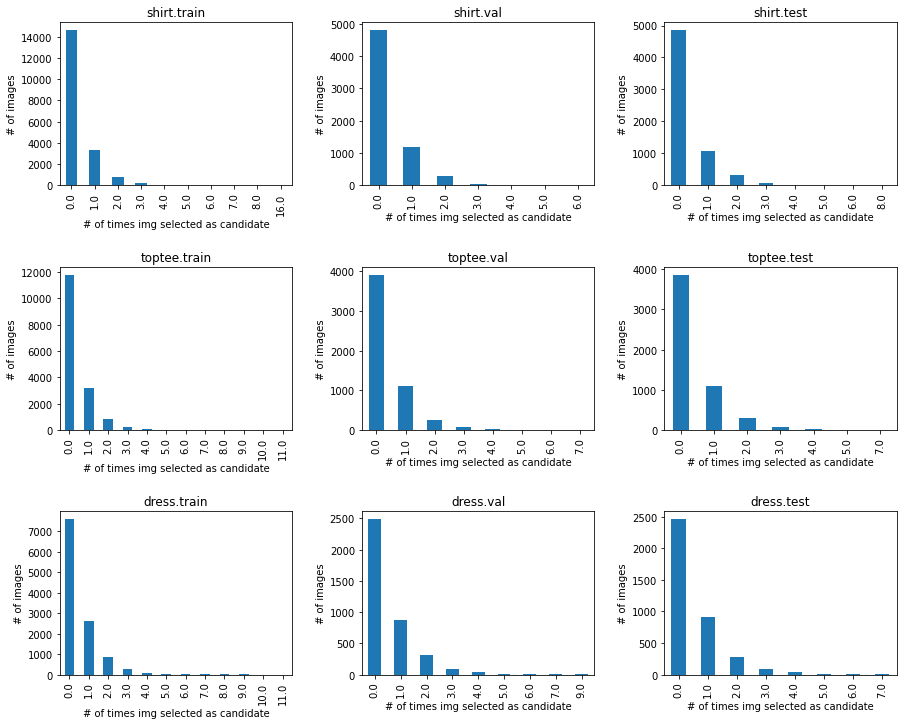

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

for i, img_type in enumerate(img_types):
    caption_df = caption_dfs[img_type]
    for j, split_type in enumerate(split_types):
        img_candidate_counts = caption_df[caption_df['split_type'] == split_type].groupby('candidate').size().to_frame().reset_index()
        img_candidate_counts.columns = ['img', 'candidate_count']

        split_imgs = pd.read_json(f'{data_ext_path}/image_splits/split.{img_type}.{split_type}.json')
        split_imgs.columns = ['img']

        # Ensure img_candidate_counts doesn't have image ids that aren't included the respective split
        assert len(split_imgs.merge(img_candidate_counts, on='img')) == len(img_candidate_counts)

        img_candidate_counts = split_imgs.merge(img_candidate_counts, on='img', how='left').fillna(0)
        img_candidate_counts['candidate_count'].value_counts().sort_index().plot.bar(ax=ax[i-1, j-1])

        ax[i-1, j-1].set_title(f'{img_type}.{split_type}')
        ax[i-1, j-1].set_xlabel('# of times img selected as candidate')
        ax[i-1, j-1].set_ylabel('# of images')

Looks like they all follow a pretty similar distribution where **a majority of images are never used as a candidate image**, while a couple are used many times. Does the same apply for the number of times each image is used as a target image?

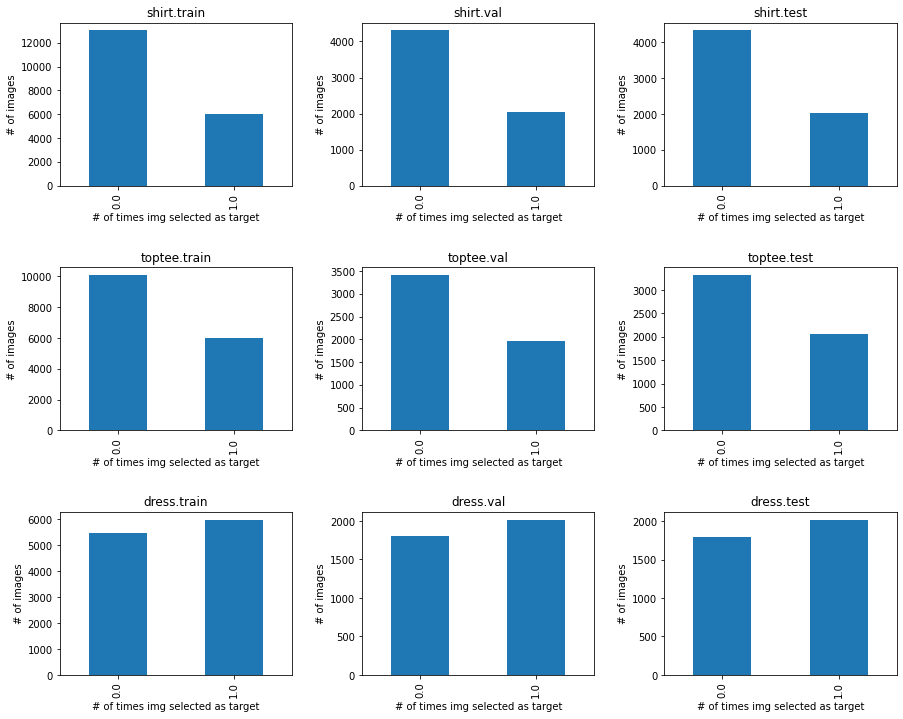

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

for i, img_type in enumerate(img_types):
    caption_df = caption_dfs[img_type]
    for j, split_type in enumerate(split_types):
        img_target_counts = caption_df[caption_df['split_type'] == split_type].groupby('target').size().to_frame().reset_index()
        img_target_counts.columns = ['img', 'target_count']

        split_imgs = pd.read_json(f'{data_ext_path}/image_splits/split.{img_type}.{split_type}.json')
        split_imgs.columns = ['img']

        # Ensure img_target_counts doesn't have image ids that aren't included the respective split
        assert len(split_imgs.merge(img_target_counts, on='img')) == len(img_target_counts)

        img_target_counts = split_imgs.merge(img_target_counts, on='img', how='left').fillna(0)
        img_target_counts['target_count'].value_counts().sort_index().plot.bar(ax=ax[i-1, j-1])

        ax[i-1, j-1].set_title(f'{img_type}.{split_type}')
        ax[i-1, j-1].set_xlabel('# of times img selected as target')
        ax[i-1, j-1].set_ylabel('# of images')

In general, we have the following observations:

1. Images are __slightly more likely__ to have been selected as a target at least once than a candidate at least once.
2. __No image__ in any of the splits is selected as a target image more than 1 time.
3. For both candidate and target images, the **number of images referenced at least once stays consistent** across all image types (dress, shirt, toptee). Instead, the number of images which *aren't referenced* increases as the number of images in the respective split also increases.

Since there are so many images that haven't been selected as a candidate & haven't been selected as a target, we'd like to see the overlap. How many images have been referenced at least once as either a target or candidate in the captions? How many have 0 references?

In [15]:
for img_type in img_types:
    caption_df = caption_dfs[img_type]
    for split_type in split_types:
        img_candidate_counts = caption_df[caption_df['split_type'] == split_type].groupby('candidate').size().to_frame().reset_index()
        img_candidate_counts.columns = ['img', 'candidate_count']
        img_target_counts = caption_df[caption_df['split_type'] == split_type].groupby('target').size().to_frame().reset_index()
        img_target_counts.columns = ['img', 'target_count']

        split_imgs = pd.read_json(f'{data_ext_path}/image_splits/split.{img_type}.{split_type}.json')
        split_imgs.columns = ['img']

        candidate_target_counts = (split_imgs.merge(img_candidate_counts, on='img', how='left')
                                             .merge(img_target_counts, on='img', how='left'))

        one_or_more_refs = candidate_target_counts[candidate_target_counts[['candidate_count', 'target_count']].notnull().any(axis=1)]
        print(f'{img_type}.{split_type}: {len(one_or_more_refs)}/{len(split_imgs)} imgs referenced >=1 times (candidate OR target)'
               f' in captions    {round((len(one_or_more_refs) / len(split_imgs)) * 100, 0)}%')
    print()


dress.test: 2667/3818 imgs referenced >=1 times (candidate OR target) in captions    70.0%
dress.train: 7757/11452 imgs referenced >=1 times (candidate OR target) in captions    68.0%
dress.val: 2628/3817 imgs referenced >=1 times (candidate OR target) in captions    69.0%

shirt.test: 3053/6346 imgs referenced >=1 times (candidate OR target) in captions    48.0%
shirt.train: 8988/19036 imgs referenced >=1 times (candidate OR target) in captions    47.0%
shirt.val: 3089/6346 imgs referenced >=1 times (candidate OR target) in captions    49.0%

toptee.test: 2965/5374 imgs referenced >=1 times (candidate OR target) in captions    55.0%
toptee.train: 8695/16121 imgs referenced >=1 times (candidate OR target) in captions    54.0%
toptee.val: 2902/5373 imgs referenced >=1 times (candidate OR target) in captions    54.0%



We see that the number of images referenced at least once (as a candidate or target) in the captions isn't all that different across image types (dress, shirt, toptee), although it does increase slightly as there are more images. Similar to the patterns observed when observing candidate and target image references individually, the number of images that **aren't referenced** in the captions increases as the image split gets bigger in size/count.

## 4. Remove references to missing images from captions

Because not all the images are available (i.e., not all of them could be downloaded), it doesn't make sense for the captions to reference any images that aren't accessible. As a result, we'll be removing all of these entries from the caption dataframes.

In [16]:
valid_caption_dfs = dict.fromkeys(img_types)

for i, img_type in enumerate(img_types):
    missing_imgs = missing_dfs[i]['id']
    caption_df = caption_dfs[img_type]
    missing_candidates = caption_df['candidate'].isin(missing_imgs)
    missing_targets = caption_df['target'].isin(missing_imgs)
    valid_caption_df = caption_df[~(missing_candidates | missing_targets)]
    valid_caption_dfs[img_type] = valid_caption_df

    for split_type in split_types:
        split_captions = caption_df[caption_df['split_type'] == split_type]
        split_valid_captions = valid_caption_df[valid_caption_df['split_type'] == split_type]
        print(f'Type: {img_type}.{split_type}', '| Total captions:', len(split_captions),
            '| Adjusted captions:', len(split_valid_captions),
            f'| Percent decrease: {round(100 * (1 - (len(split_captions) / len(split_valid_captions))), 2)}%')
    
    print()


Type: dress.test | Total captions: 2021 | Adjusted captions: 1824 | Percent decrease: -10.8%
Type: dress.train | Total captions: 5985 | Adjusted captions: 5473 | Percent decrease: -9.36%
Type: dress.val | Total captions: 2017 | Adjusted captions: 1869 | Percent decrease: -7.92%

Type: shirt.test | Total captions: 2014 | Adjusted captions: 1899 | Percent decrease: -6.06%
Type: shirt.train | Total captions: 5988 | Adjusted captions: 5663 | Percent decrease: -5.74%
Type: shirt.val | Total captions: 2038 | Adjusted captions: 1948 | Percent decrease: -4.62%

Type: toptee.test | Total captions: 2053 | Adjusted captions: 1981 | Percent decrease: -3.63%
Type: toptee.train | Total captions: 6027 | Adjusted captions: 5782 | Percent decrease: -4.24%
Type: toptee.val | Total captions: 1961 | Adjusted captions: 1877 | Percent decrease: -4.48%



There doesn't seem to be a super significant decrease in any of the caption counts, so we'll still be able to use this data.

## 5. Ensure no inconsistencies with updated data

As a sanity check, we'll ensure that the updated data (without the missing image captions) still follow a similar distribution with regards to the number of times each images is selected as (1) a candidate image and (2) a target image.

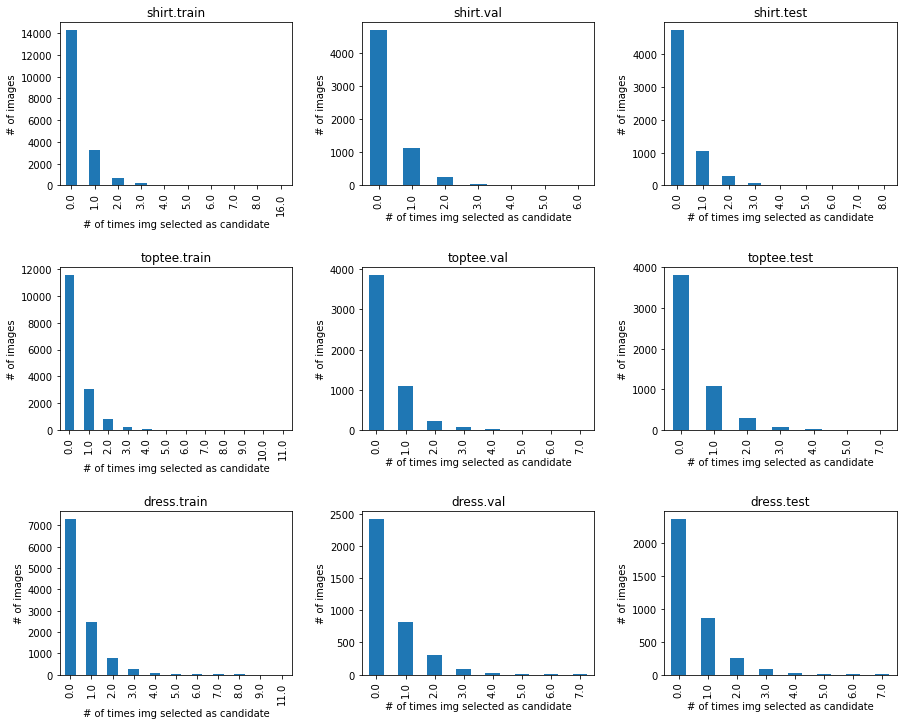

In [17]:
# Candidate distribution
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

for i, img_type in enumerate(img_types):
    caption_df = valid_caption_dfs[img_type]
    for j, split_type in enumerate(split_types):
        img_candidate_counts = caption_df[caption_df['split_type'] == split_type].groupby('candidate').size().to_frame().reset_index()
        img_candidate_counts.columns = ['img', 'candidate_count']

        split_imgs = glob.glob(f'{data_raw_path}/{img_type}/{split_type}/*.jpg')
        split_imgs = pd.DataFrame([f.split('/')[-1].split('.')[0] for f in split_imgs], columns=['img'])

        # Ensure img_candidate_counts doesn't have image ids that aren't included the respective split
        assert len(split_imgs.merge(img_candidate_counts, on='img')) == len(img_candidate_counts)

        img_candidate_counts = split_imgs.merge(img_candidate_counts, on='img', how='left').fillna(0)
        img_candidate_counts['candidate_count'].value_counts().sort_index().plot.bar(ax=ax[i-1, j-1])

        ax[i-1, j-1].set_title(f'{img_type}.{split_type}')
        ax[i-1, j-1].set_xlabel('# of times img selected as candidate')
        ax[i-1, j-1].set_ylabel('# of images')

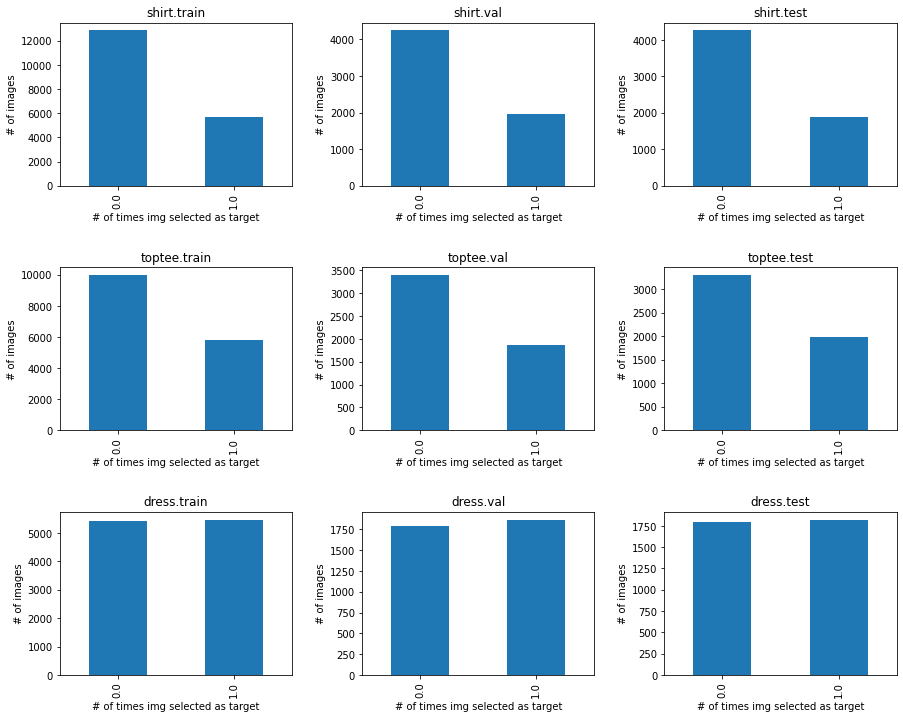

In [18]:
# Target distribution
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

for i, img_type in enumerate(img_types):
    caption_df = valid_caption_dfs[img_type]
    for j, split_type in enumerate(split_types):
        img_target_counts = caption_df[caption_df['split_type'] == split_type].groupby('target').size().to_frame().reset_index()
        img_target_counts.columns = ['img', 'target_count']

        split_imgs = glob.glob(f'{data_raw_path}/{img_type}/{split_type}/*.jpg')
        split_imgs = pd.DataFrame([f.split('/')[-1].split('.')[0] for f in split_imgs], columns=['img'])

        # Ensure img_target_counts doesn't have image ids that aren't included the respective split
        assert len(split_imgs.merge(img_target_counts, on='img')) == len(img_target_counts)

        img_target_counts = split_imgs.merge(img_target_counts, on='img', how='left').fillna(0)
        img_target_counts['target_count'].value_counts().sort_index().plot.bar(ax=ax[i-1, j-1])

        ax[i-1, j-1].set_title(f'{img_type}.{split_type}')
        ax[i-1, j-1].set_xlabel('# of times img selected as target')
        ax[i-1, j-1].set_ylabel('# of images')

## 6. Save updated captions

We save the updated captions (without missing images) in the `data/raw` folder.

In [19]:
for img_type, df in valid_caption_dfs.items():
    for split_type in split_types:
        captions_dir = Path(f'{data_raw_path}/captions')
        # create directory + missing parents. Is OK if directory already exists
        captions_dir.mkdir(parents=True, exist_ok=True)

        split_captions = df[df['split_type'] == split_type].drop(columns=['img_type', 'split_type'])
        split_captions.to_json(f'{data_raw_path}/captions/cap.{img_type}.{split_type}.json', orient='records')

## Next steps

Data preprocessing needs to take place before actually training the model. This likely includes (but is not limited to):
- Resizing images to consistent format
- Stemming, tokenization, spellchecking of captions
- Accounting for skewed data distributions